In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)


In [3]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv", index_col=0) 
df2=pd.read_csv("WBA.csv", index_col=0)  
df3=pd.read_csv("MTRAF.csv", index_col=0)
df4=pd.read_csv("COOP.csv", index_col=0) 
df5=pd.read_csv("JSAIY.csv", index_col=0)  
df6=pd.read_csv("ADRNY.csv", index_col=0)  
df7=pd.read_csv("TSCDY.csv", index_col=0)  
df8=pd.read_csv("KR.csv", index_col=0)    
df9=pd.read_csv("AGHC.csv", index_col=0)  
df10=pd.read_csv("CRRFY.csv", index_col=0) 
df11=pd.read_csv("WNGRF.csv", index_col=0) 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
df1

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,22.240000,22.809999,22.230000,22.790001,22.790001,385800
1,2016-01-05,22.610001,22.750000,22.480000,22.670000,22.670000,52600
2,2016-01-06,22.370001,22.520000,22.209999,22.389999,22.389999,66000
3,2016-01-07,22.350000,22.629999,22.150000,22.629999,22.629999,49900
4,2016-01-08,21.690001,22.030001,21.510000,21.570000,21.570000,69000
...,...,...,...,...,...,...,...
1001,2019-12-24,18.150000,18.430000,18.150000,18.379999,18.379999,29000
1002,2019-12-26,18.280001,18.370001,18.280001,18.299999,18.299999,50500
1003,2019-12-27,18.690001,18.690001,18.280001,18.389999,18.389999,55100
1004,2019-12-30,17.940001,18.290001,17.940001,18.230000,18.230000,70900


# Make models (train)

In [4]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], outputs_company=1, train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  print(f"[Arguments]") 
  print(f"num_company={len(nl)}社 {nl}")
  print(f"input_item={v}, outout_item={output_i}, output_category={output_c}")
  print(f"train_size={train_size}, time_step={time_step}, num_epoch={epochs}, num_units(neurons)={units}")
  print("")

  print("~~Make models~~")
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print("SECTOR1")
    # print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    # print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("SECTOR1-1")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      # print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("SECTOR1-2")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      # print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    print("SECTOR2")
    if V:
      print("SECTOR2-1[Volume1つを予測]")

      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))
      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)

      # print(f"concat={ss_v.shape}")

      ind = [id for id in range(len(c))]
      # print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(ss_v[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(ss_v[j, ind[k]])

    else: # volume含まれていない時
      print("SECTOR2-2[Volume以外１つを予測]")
      # from sklearn.preprocessing import MinMaxScaler#確認用
      # ss３=MinMaxScaler(feature_range=(0,1))

      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()

      concat=ss2.fit_transform(training_set_all)

      ind = [id for id in range(len(c))]

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  model_lists = []
  
  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")

    model = Sequential()

    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  return model_lists, y_trains2[:outputs_company]

# Make predictions (test)


In [5]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  print("~~Make predctions~~")
  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")


  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists_test=[]
  actual_lists_train=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists_test+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
    actual_lists_train+=[sc.iloc[:train_size,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual_lists_train={np.array(actual_lists_train).shape}, actual_lists_test={np.array(actual_lists_test).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(f"[{output_c}]")
  
  plt.figure(figsize=(18, 27))
  scores_list=[]
  for p in range(len(R2)):
    plt.subplot(4, 2, p+1) 
    plt.plot(c[0].loc[:train_size-1,'Date'], actual_lists_train[p], color='black', label='Real(Trainning)')
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists_test[p], color='red', label='Real(Test)')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    plt.xticks(np.arange(0, 1006, 251))
    plt.xlabel('Date')
    if v[0]=="2": plt.ylabel('High Price')
    else: plt.ylabel('Volume')
    
    from sklearn.metrics import r2_score
    r2=round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)
    scores_list.append(r2)
    plt.title(f"R2: {R2[p]}={round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)}")

    R +=r2_score(actual_lists_test[p], preds[p].flatten())
    plt.legend()
  plt.show()

  if p in r:
    scores_list.append(round(R/len(c), 4))
    print(f"R2-{len(c)}companies_average={round(R/len(c), 4)}")
    R=0
    print("")
  print(f"R2_scores_lists={scores_list}")

  #6. Make confusion matrix

  # columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  # for p in range(len(output_i)):
  #   print(f"Preds_Heatmap={output_c[p]} correlation")
  #   prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
  #   # print(len(prd))
  #   Preds= pd.DataFrame(np.concatenate(prd, axis=1))
  #   Preds.columns = columns
  #   # print(Preds.columns)
  #   plt.figure(figsize=(8, 6))
  #   cmap=sns.diverging_palette(220, 20, as_cmap=True)
  #   sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# 6月22日以降　


## ALL in ALL Function

In [6]:
all_data=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
import random

def all_in_all(original_all_data, num_company=11, input_num=[2], output_category=['High'], output_num=[2], outputs_company=11, 
               train_size=754, time_step=60, epochs=20, units=50):

  all_companies_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

  # Pick up companies rondomly
  company_list=random.sample(all_companies_list, num_company) 
  
  all_data=[]
  for d in range(num_company):
    ind = all_companies_list.index(company_list[d])
    all_data.append(original_all_data[ind])
  
  if 6 not in input_num: Volume=False
  else: Volume=True

  # Make Models
  # Arguments: c, nl, v, V=False, output_c=['High'], output_i=[2], outputs_company=1, train_size=754, time_step=60, epochs=30, units=50
  model_lists, y_trains = make_models(all_data, company_list, input_num, Volume, output_category, 
                                      output_num, outputs_company, train_size, time_step, epochs, units)
  # Make Predictions   
  # Arguments: c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60)          
  make_preds(all_data, company_list, input_num, model_lists, y_trains, Volume, output_category, output_num, train_size, time_step)

## 集計用

# `High` N=2~7(Random＊10set) Box Plot 作成用

1回目
False
[Arguments]
num_company=2社 ['Metro (Canada)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 22s 215ms/step - loss: 0.4377
Epoch 2/50
22/22 [==============================] - 5s 209ms/step - loss: 0.1941
Epoch 3/50
22/22 [==============================] - 5s 226ms/step - loss: 0.1675
Epoch 4/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1514
Epoch 5/50
22/22 [==============================] - 5s 204ms/step - loss: 0.1550
Epoch 6/50
22/22 [==============================] - 5s 205ms/step - loss: 0.1474
Epoch 7/50
22/22 [==============================] - 5s 207ms/step - loss: 0.1339
Epoch 8/50
22/22 [==============================] - 5s 206m

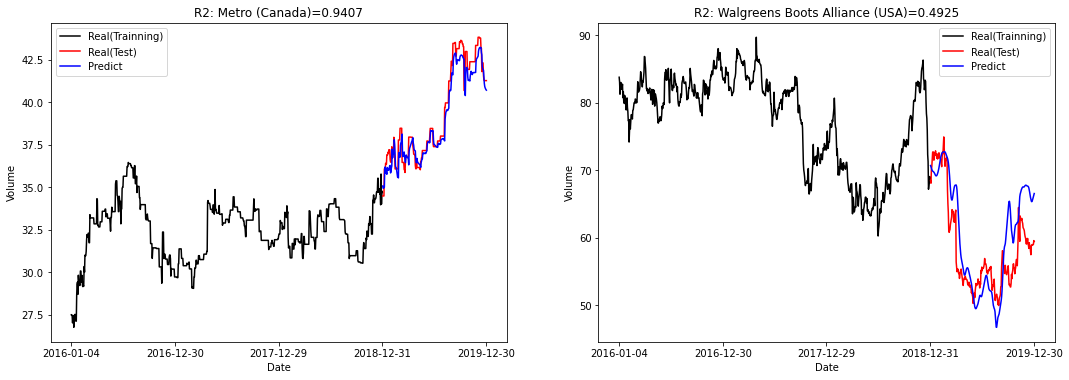

R2-2companies_average=0.7166

R2_scores_lists=[0.9407, 0.4925, 0.7166]
2回目
False
[Arguments]
num_company=2社 ['Tesco(Britain)', 'Royal Ahold Delhaize(Netherlands)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 14s 206ms/step - loss: 0.4069
Epoch 2/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1164
Epoch 3/50
22/22 [==============================] - 5s 216ms/step - loss: 0.1102
Epoch 4/50
22/22 [==============================] - 5s 207ms/step - loss: 0.1062
Epoch 5/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0741
Epoch 6/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0842
Epoch 7/50
22/22 [==============================] - 5s 207ms/step 

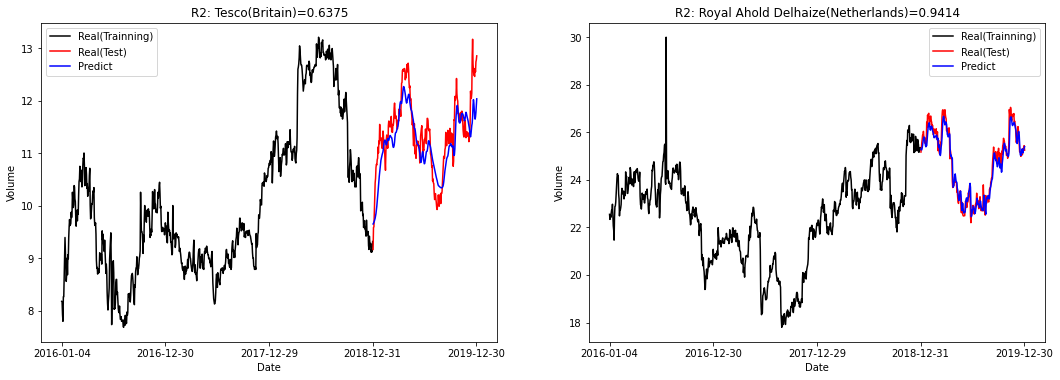

R2-2companies_average=0.7895

R2_scores_lists=[0.6375, 0.9414, 0.7895]
3回目
False
[Arguments]
num_company=2社 ['J.Sainsbury(Britain)', 'AEON(Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 14s 230ms/step - loss: 0.5607
Epoch 2/50
22/22 [==============================] - 5s 235ms/step - loss: 0.1864
Epoch 3/50
22/22 [==============================] - 5s 235ms/step - loss: 0.1325
Epoch 4/50
22/22 [==============================] - 6s 266ms/step - loss: 0.1252
Epoch 5/50
22/22 [==============================] - 6s 263ms/step - loss: 0.1121
Epoch 6/50
22/22 [==============================] - 7s 316ms/step - loss: 0.1140
Epoch 7/50
22/22 [==============================] - 5s 240ms/step - loss: 0.0990
E

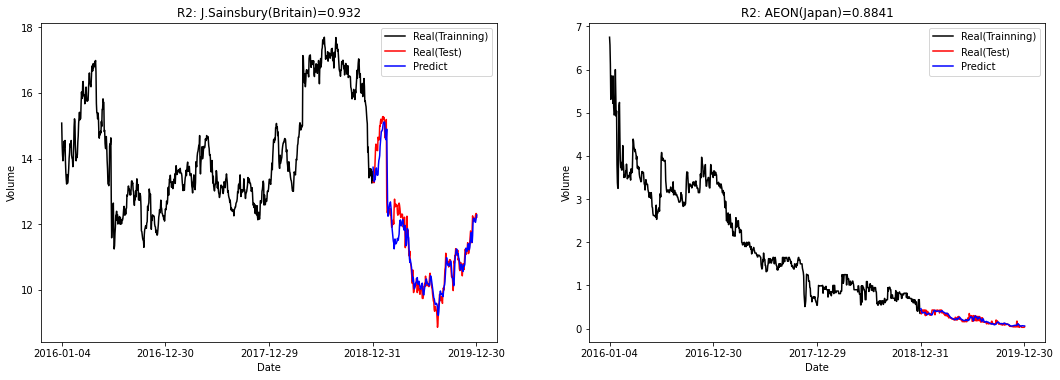

R2-2companies_average=0.908

R2_scores_lists=[0.932, 0.8841, 0.908]
4回目
False
[Arguments]
num_company=2社 ['Coop Group (Switzerland)', 'Tesco(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 14s 227ms/step - loss: 0.2830
Epoch 2/50
22/22 [==============================] - 5s 224ms/step - loss: 0.0704
Epoch 3/50
22/22 [==============================] - 5s 232ms/step - loss: 0.0579
Epoch 4/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0473
Epoch 5/50
22/22 [==============================] - 5s 213ms/step - loss: 0.0480
Epoch 6/50
22/22 [==============================] - 5s 207ms/step - loss: 0.0450
Epoch 7/50
22/22 [==============================] - 5s 218ms/step - loss: 0.04

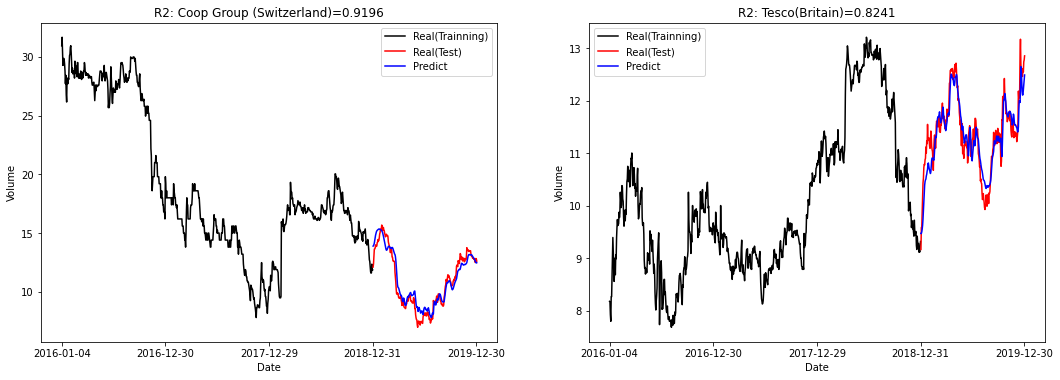

R2-2companies_average=0.8719

R2_scores_lists=[0.9196, 0.8241, 0.8719]
5回目
False
[Arguments]
num_company=2社 ['AEON(Japan)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 11s 206ms/step - loss: 0.2703
Epoch 2/50
22/22 [==============================] - 5s 229ms/step - loss: 0.0525
Epoch 3/50
22/22 [==============================] - 5s 212ms/step - loss: 0.0422
Epoch 4/50
22/22 [==============================] - 5s 210ms/step - loss: 0.0350
Epoch 5/50
22/22 [==============================] - 5s 206ms/step - loss: 0.0495
Epoch 6/50
22/22 [==============================] - 5s 212ms/step - loss: 0.0343
Epoch 7/50
22/22 [==============================] - 5s 216ms/step - loss: 0.0331
Epoc

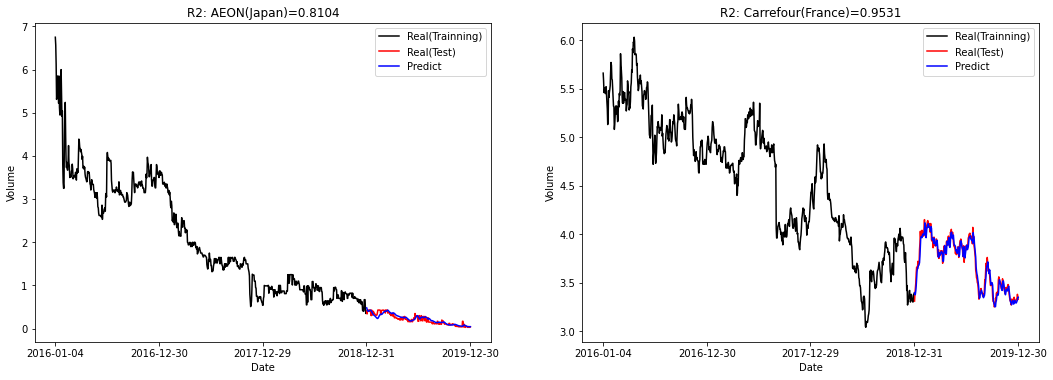

R2-2companies_average=0.8817

R2_scores_lists=[0.8104, 0.9531, 0.8817]
6回目
False
[Arguments]
num_company=2社 ['George Weston(Canada)', 'Seven & I Holdings (Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 14s 218ms/step - loss: 0.3346
Epoch 2/50
22/22 [==============================] - 5s 214ms/step - loss: 0.1414
Epoch 3/50
22/22 [==============================] - 5s 230ms/step - loss: 0.1211
Epoch 4/50
22/22 [==============================] - 5s 207ms/step - loss: 0.1043
Epoch 5/50
22/22 [==============================] - 5s 207ms/step - loss: 0.1287
Epoch 6/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0929
Epoch 7/50
22/22 [==============================] - 5s 209ms/step 

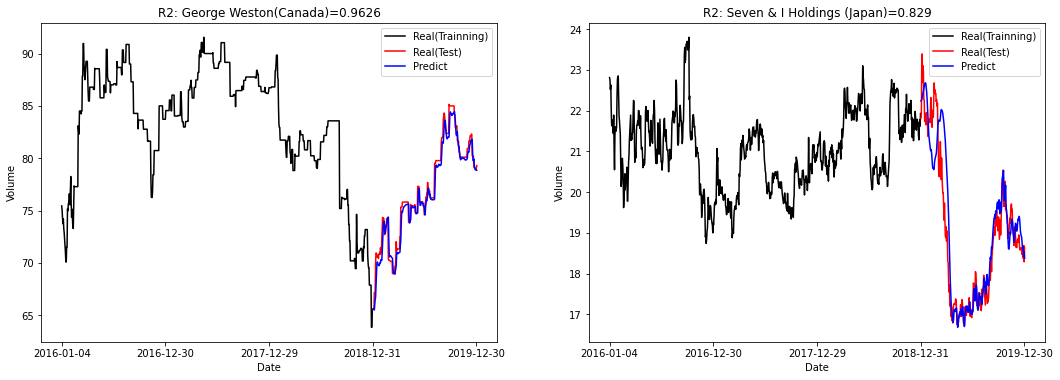

R2-2companies_average=0.8958

R2_scores_lists=[0.9626, 0.829, 0.8958]
7回目
False
[Arguments]
num_company=2社 ['Metro (Canada)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 224ms/step - loss: 0.5211
Epoch 2/50
22/22 [==============================] - 5s 216ms/step - loss: 0.2300
Epoch 3/50
22/22 [==============================] - 5s 211ms/step - loss: 0.1919
Epoch 4/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1566
Epoch 5/50
22/22 [==============================] - 5s 210ms/step - loss: 0.1396
Epoch 6/50
22/22 [==============================] - 5s 213ms/step - loss: 0.1469
Epoch 7/50
22/22 [==============================] - 5s 215ms/step - loss: 0.1315
Ep

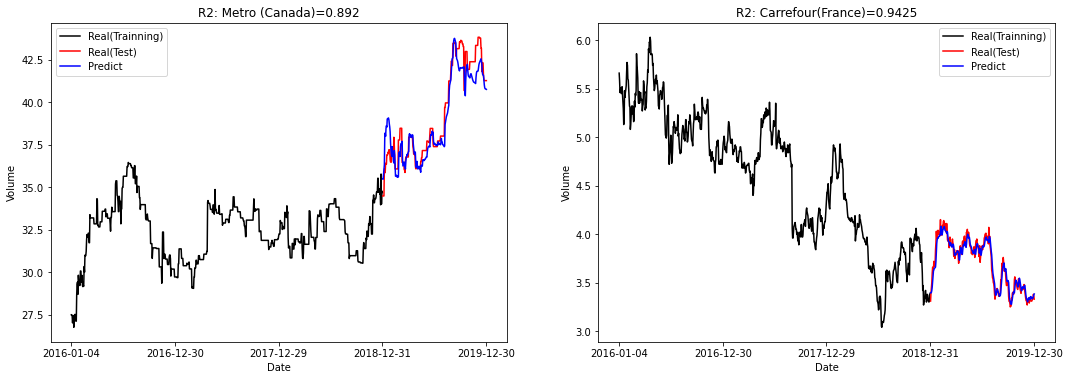

R2-2companies_average=0.9173

R2_scores_lists=[0.892, 0.9425, 0.9173]
8回目
False
[Arguments]
num_company=2社 ['Coop Group (Switzerland)', 'Royal Ahold Delhaize(Netherlands)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 11s 211ms/step - loss: 0.3404
Epoch 2/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0802
Epoch 3/50
22/22 [==============================] - 5s 216ms/step - loss: 0.0558
Epoch 4/50
22/22 [==============================] - 5s 228ms/step - loss: 0.0502
Epoch 5/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0445
Epoch 6/50
22/22 [==============================] - 5s 227ms/step - loss: 0.0368
Epoch 7/50
22/22 [==============================] - 5s 22

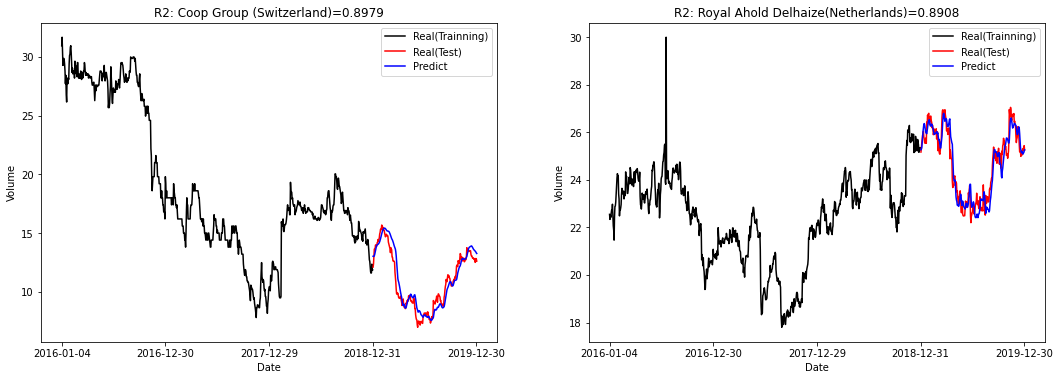

R2-2companies_average=0.8944

R2_scores_lists=[0.8979, 0.8908, 0.8944]
9回目
False
[Arguments]
num_company=2社 ['Walgreens Boots Alliance (USA)', 'Royal Ahold Delhaize(Netherlands)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 16s 259ms/step - loss: 0.4852
Epoch 2/50
22/22 [==============================] - 5s 244ms/step - loss: 0.2205
Epoch 3/50
22/22 [==============================] - 5s 242ms/step - loss: 0.1760
Epoch 4/50
22/22 [==============================] - 5s 232ms/step - loss: 0.1317
Epoch 5/50
22/22 [==============================] - 5s 232ms/step - loss: 0.1175
Epoch 6/50
22/22 [==============================] - 5s 251ms/step - loss: 0.1231
Epoch 7/50
22/22 [==============================] 

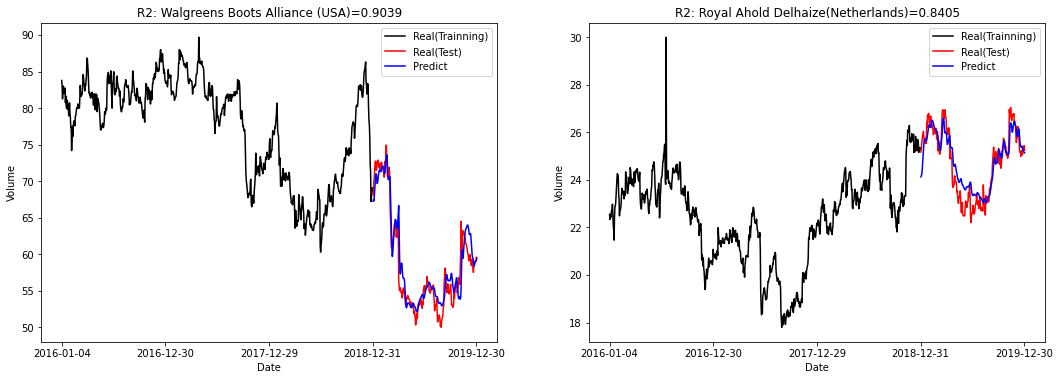

R2-2companies_average=0.8722

R2_scores_lists=[0.9039, 0.8405, 0.8722]
10回目
False
[Arguments]
num_company=2社 ['Royal Ahold Delhaize(Netherlands)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 227ms/step - loss: 0.5563
Epoch 2/50
22/22 [==============================] - 5s 212ms/step - loss: 0.2007
Epoch 3/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1494
Epoch 4/50
22/22 [==============================] - 5s 216ms/step - loss: 0.1265
Epoch 5/50
22/22 [==============================] - 5s 210ms/step - loss: 0.1200
Epoch 6/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1439
Epoch 7/50
22/22 [==============================] - 5s 227ms/s

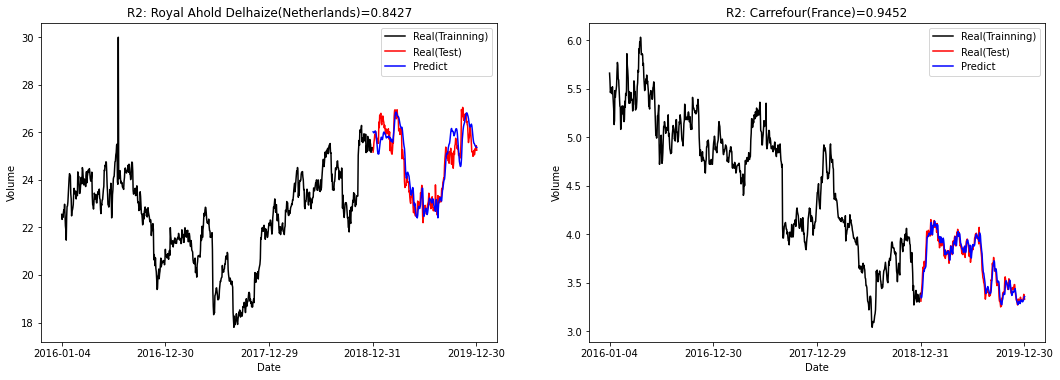

R2-2companies_average=0.8939

R2_scores_lists=[0.8427, 0.9452, 0.8939]


In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}回目")
  all_in_all(all_data, num_company=2, input_num=[2], output_category=['High'], output_num=[2], outputs_company=2,
           train_size=754, time_step=60, epochs=50, units=100)

1回目
[Arguments]
num_company=3社 ['George Weston(Canada)', 'Royal Ahold Delhaize(Netherlands)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 27s 201ms/step - loss: 0.4827
Epoch 2/50
22/22 [==============================] - 4s 196ms/step - loss: 0.1353
Epoch 3/50
22/22 [==============================] - 4s 195ms/step - loss: 0.1114
Epoch 4/50
22/22 [==============================] - 4s 196ms/step - loss: 0.0959
Epoch 5/50
22/22 [==============================] - 4s 196ms/step - loss: 0.1154
Epoch 6/50
22/22 [==============================] - 4s 196ms/step - loss: 0.0976
Epoch 7/50
22/22 [==============================] - 4s 195ms/step - loss: 0.0882
Epoch 8/50
22/22 [===

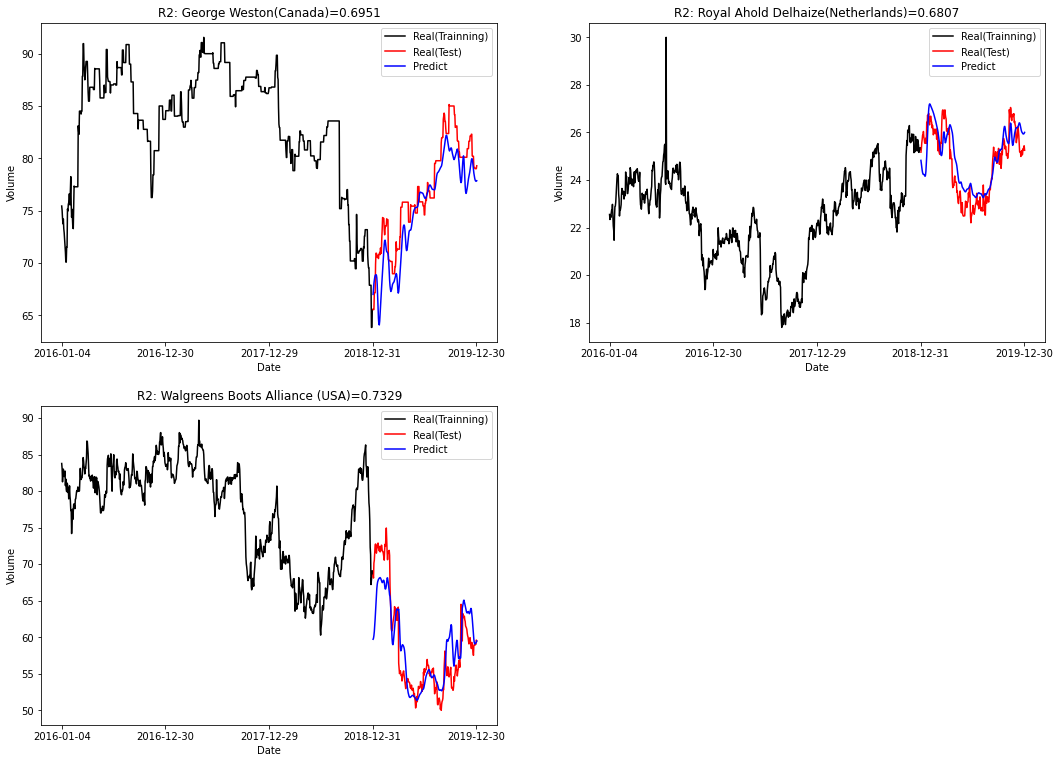

R2-3companies_average=0.7029

R2_scores_lists=[0.6951, 0.6807, 0.7329, 0.7029]
2回目
[Arguments]
num_company=3社 ['Walgreens Boots Alliance (USA)', 'Carrefour(France)', 'Coop Group (Switzerland)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 199ms/step - loss: 0.5658
Epoch 2/50
22/22 [==============================] - 4s 202ms/step - loss: 0.1830
Epoch 3/50
22/22 [==============================] - 4s 203ms/step - loss: 0.1170
Epoch 4/50
22/22 [==============================] - 4s 200ms/step - loss: 0.1152
Epoch 5/50
22/22 [==============================] - 4s 201ms/step - loss: 0.0836
Epoch 6/50
22/22 [==============================] - 4s 201ms/step - loss: 0.0771
Epoch 7/50
22/22 [==================

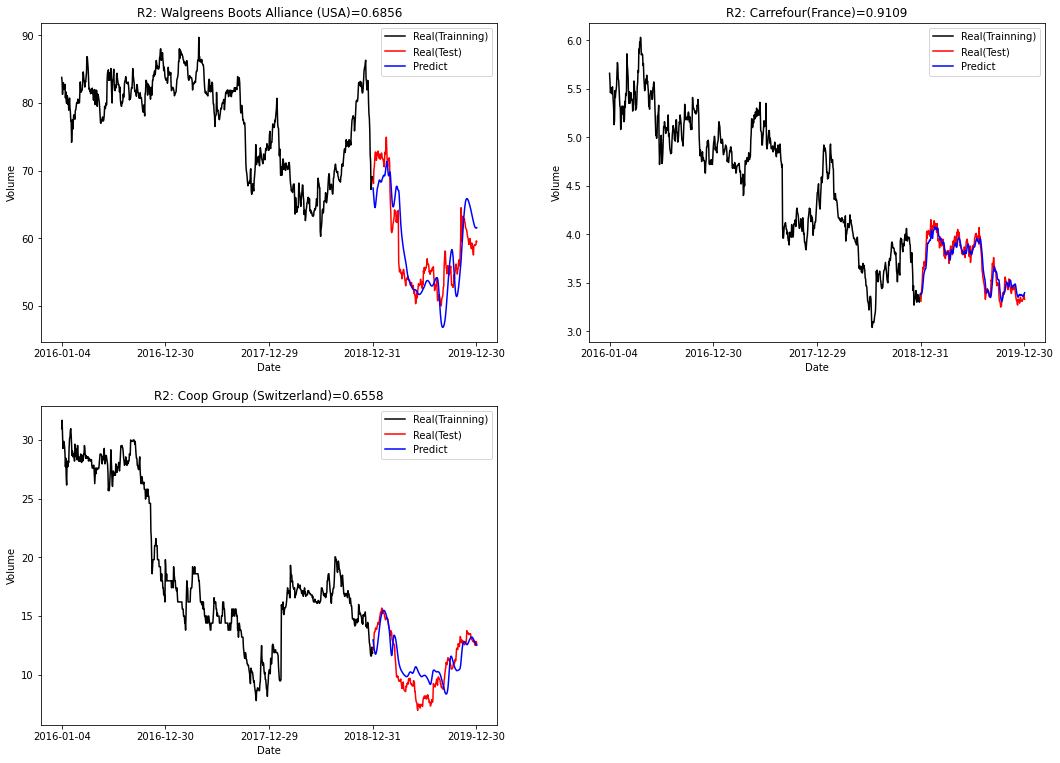

R2-3companies_average=0.7508

R2_scores_lists=[0.6856, 0.9109, 0.6558, 0.7508]
3回目
[Arguments]
num_company=3社 ['AEON(Japan)', 'Seven & I Holdings (Japan)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 203ms/step - loss: 0.3021
Epoch 2/50
22/22 [==============================] - 4s 202ms/step - loss: 0.0647
Epoch 3/50
22/22 [==============================] - 4s 202ms/step - loss: 0.0472
Epoch 4/50
22/22 [==============================] - 4s 201ms/step - loss: 0.0408
Epoch 5/50
22/22 [==============================] - 5s 206ms/step - loss: 0.0422
Epoch 6/50
22/22 [==============================] - 4s 203ms/step - loss: 0.0441
Epoch 7/50
22/22 [==============================] - 4

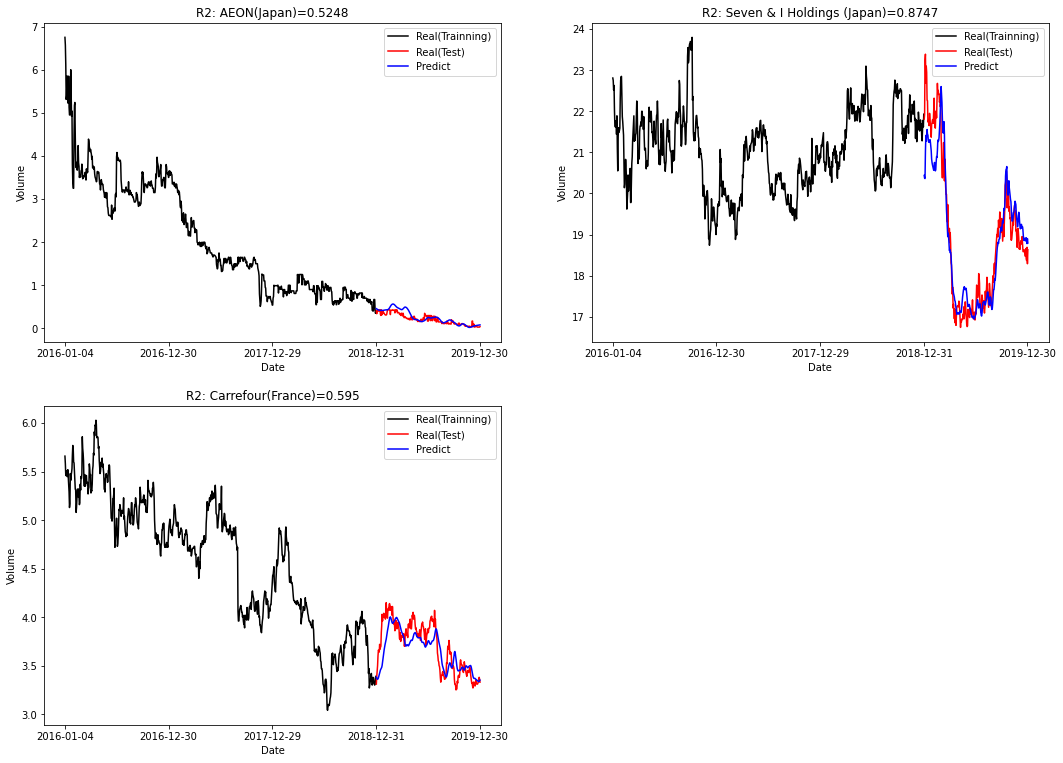

R2-3companies_average=0.6648

R2_scores_lists=[0.5248, 0.8747, 0.595, 0.6648]
4回目
[Arguments]
num_company=3社 ['Carrefour(France)', 'J.Sainsbury(Britain)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 208ms/step - loss: 0.3494
Epoch 2/50
22/22 [==============================] - 5s 204ms/step - loss: 0.1222
Epoch 3/50
22/22 [==============================] - 4s 203ms/step - loss: 0.0907
Epoch 4/50
22/22 [==============================] - 5s 204ms/step - loss: 0.0849
Epoch 5/50
22/22 [==============================] - 4s 202ms/step - loss: 0.0771
Epoch 6/50
22/22 [==============================] - 4s 202ms/step - loss: 0.0732
Epoch 7/50
22/22 [==============================] 

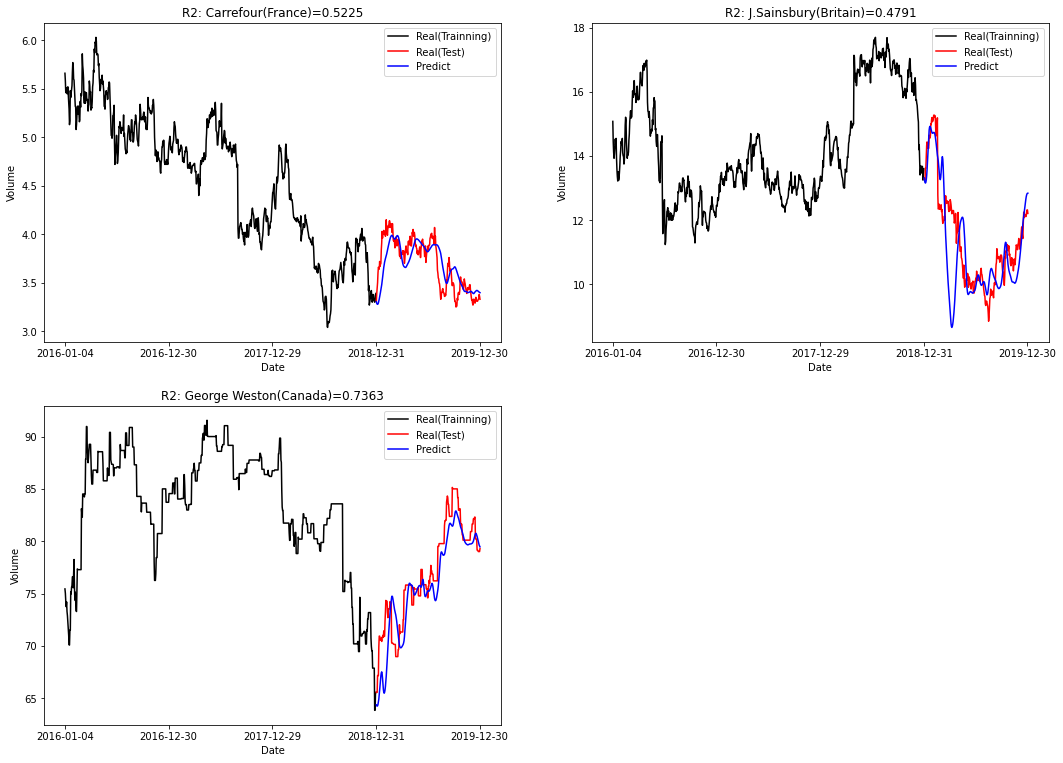

R2-3companies_average=0.5793

R2_scores_lists=[0.5225, 0.4791, 0.7363, 0.5793]
5回目
[Arguments]
num_company=3社 ['Metro (Canada)', 'Royal Ahold Delhaize(Netherlands)', 'Tesco(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 204ms/step - loss: 0.5039
Epoch 2/50
22/22 [==============================] - 5s 206ms/step - loss: 0.2259
Epoch 3/50
22/22 [==============================] - 5s 204ms/step - loss: 0.1730
Epoch 4/50
22/22 [==============================] - 4s 202ms/step - loss: 0.1687
Epoch 5/50
22/22 [==============================] - 4s 204ms/step - loss: 0.1617
Epoch 6/50
22/22 [==============================] - 5s 206ms/step - loss: 0.1420
Epoch 7/50
22/22 [============================

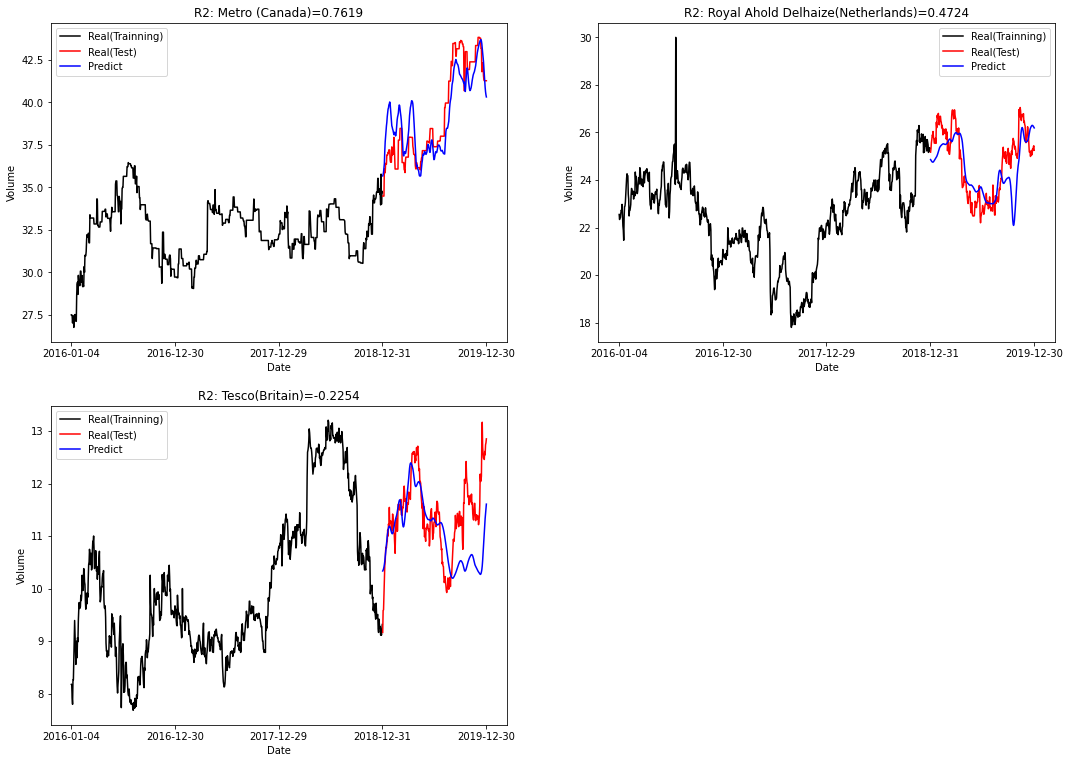

R2-3companies_average=0.3363

R2_scores_lists=[0.7619, 0.4724, -0.2254, 0.3363]
6回目
[Arguments]
num_company=3社 ['George Weston(Canada)', 'Walgreens Boots Alliance (USA)', 'Tesco(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 204ms/step - loss: 0.3828
Epoch 2/50
22/22 [==============================] - 5s 207ms/step - loss: 0.1345
Epoch 3/50
22/22 [==============================] - 5s 206ms/step - loss: 0.1360
Epoch 4/50
22/22 [==============================] - 5s 205ms/step - loss: 0.1084
Epoch 5/50
22/22 [==============================] - 5s 207ms/step - loss: 0.0960
Epoch 6/50
22/22 [==============================] - 5s 206ms/step - loss: 0.0825
Epoch 7/50
22/22 [=======================

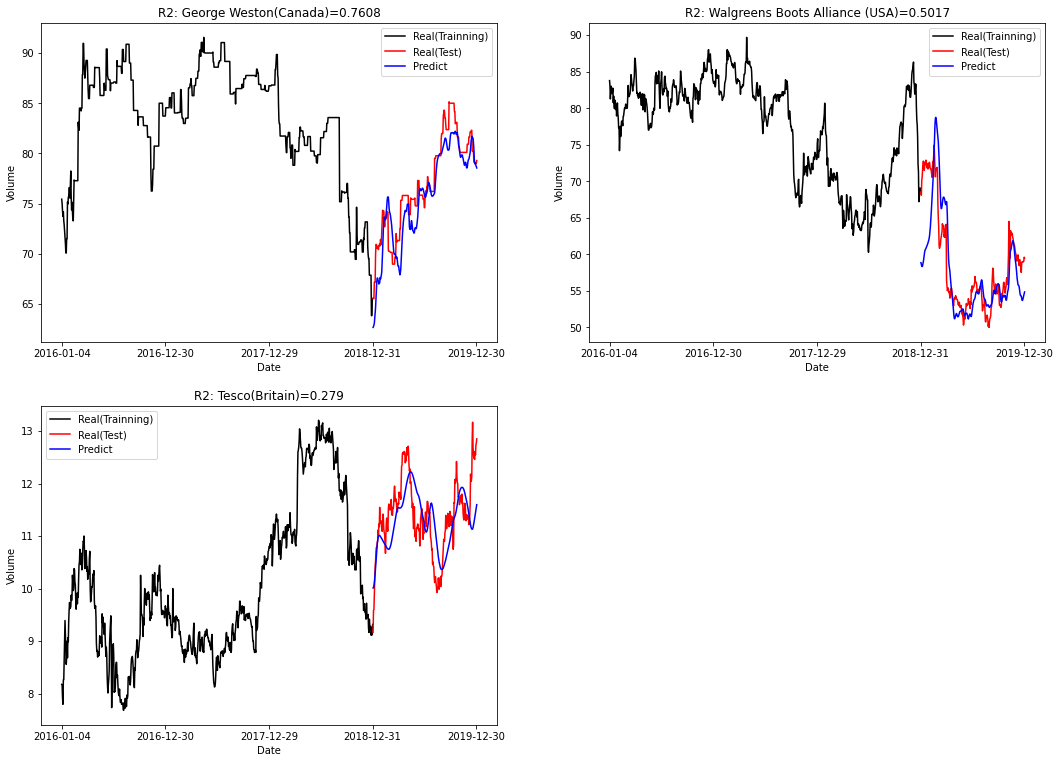

R2-3companies_average=0.5138

R2_scores_lists=[0.7608, 0.5017, 0.279, 0.5138]
7回目
[Arguments]
num_company=3社 ['Carrefour(France)', 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 207ms/step - loss: 0.3937
Epoch 2/50
22/22 [==============================] - 5s 206ms/step - loss: 0.1209
Epoch 3/50
22/22 [==============================] - 5s 209ms/step - loss: 0.0902
Epoch 4/50
22/22 [==============================] - 5s 209ms/step - loss: 0.0778
Epoch 5/50
22/22 [==============================] - 5s 209ms/step - loss: 0.0789
Epoch 6/50
22/22 [==============================] - 5s 207ms/step - loss: 0.0785
Epoch 7/50
22/22 [=============================

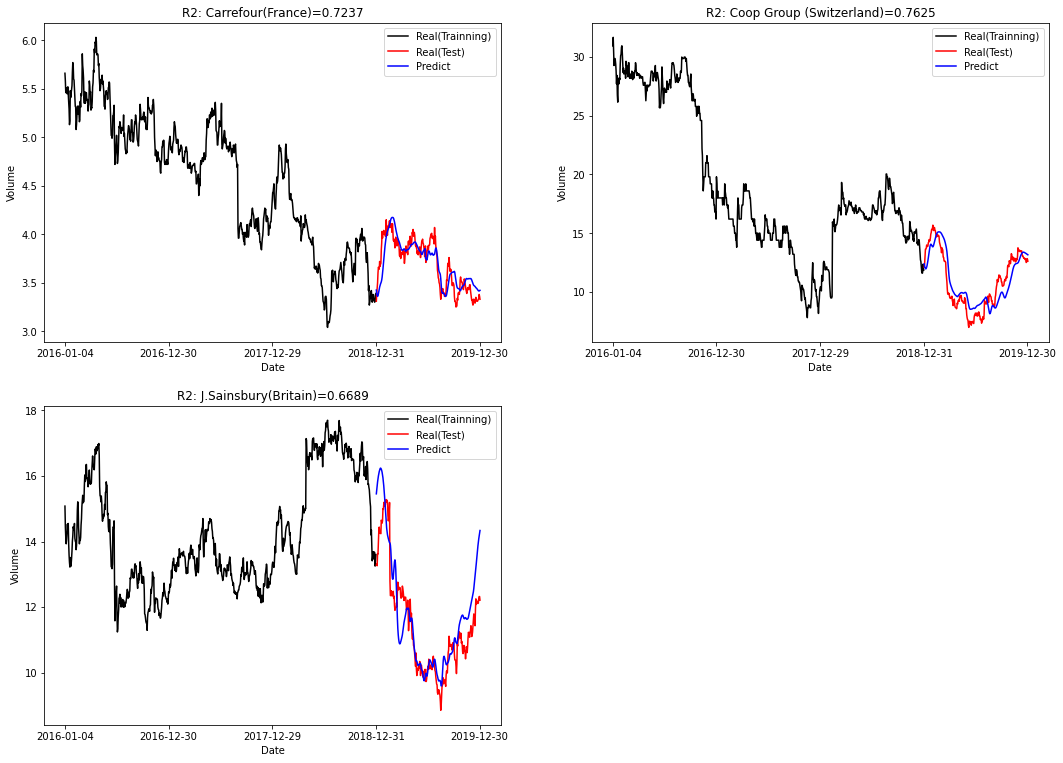

R2-3companies_average=0.7184

R2_scores_lists=[0.7237, 0.7625, 0.6689, 0.7184]
8回目
[Arguments]
num_company=3社 ['Tesco(Britain)', 'Royal Ahold Delhaize(Netherlands)', 'Metro (Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 209ms/step - loss: 0.3937
Epoch 2/50
22/22 [==============================] - 5s 210ms/step - loss: 0.1179
Epoch 3/50
22/22 [==============================] - 5s 207ms/step - loss: 0.0865
Epoch 4/50
22/22 [==============================] - 5s 206ms/step - loss: 0.0775
Epoch 5/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0727
Epoch 6/50
22/22 [==============================] - 5s 210ms/step - loss: 0.0727
Epoch 7/50
22/22 [============================

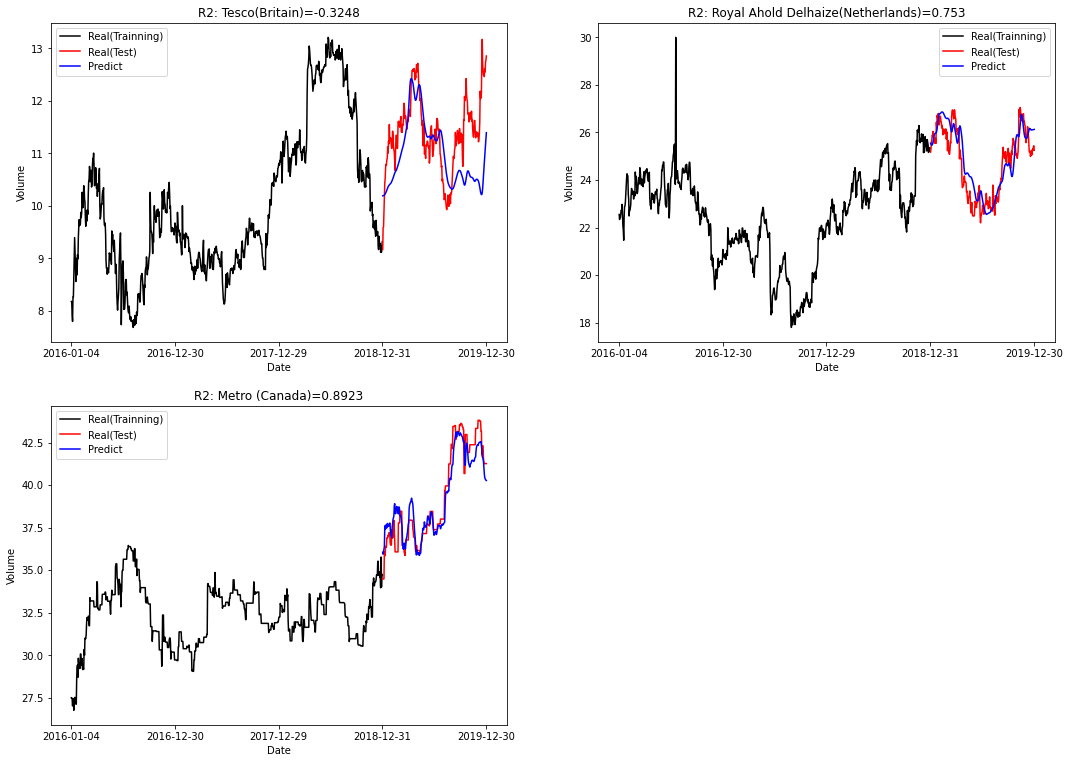

R2-3companies_average=0.4401

R2_scores_lists=[-0.3248, 0.753, 0.8923, 0.4401]
9回目
[Arguments]
num_company=3社 ['J.Sainsbury(Britain)', 'Walgreens Boots Alliance (USA)', 'Tesco(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 210ms/step - loss: 0.4947
Epoch 2/50
22/22 [==============================] - 5s 209ms/step - loss: 0.1303
Epoch 3/50
22/22 [==============================] - 5s 212ms/step - loss: 0.1415
Epoch 4/50
22/22 [==============================] - 5s 212ms/step - loss: 0.1209
Epoch 5/50
22/22 [==============================] - 5s 209ms/step - loss: 0.1023
Epoch 6/50
22/22 [==============================] - 5s 213ms/step - loss: 0.0907
Epoch 7/50
22/22 [=========================

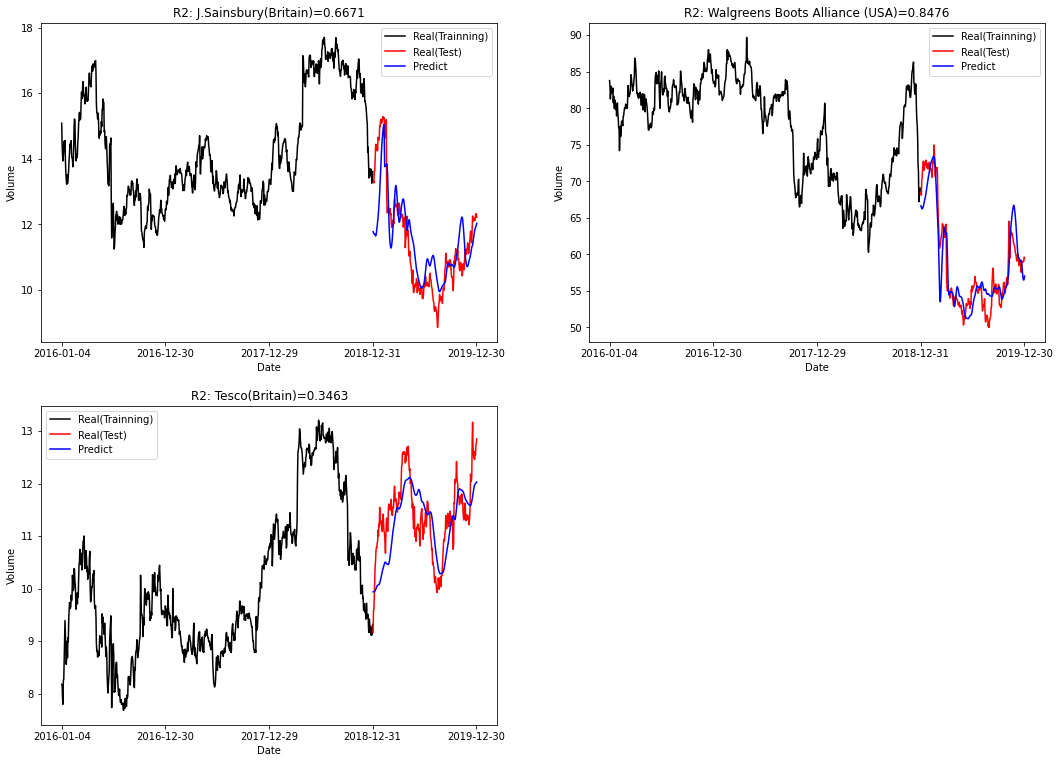

R2-3companies_average=0.6204

R2_scores_lists=[0.6671, 0.8476, 0.3463, 0.6204]
10回目
[Arguments]
num_company=3社 ['Metro (Canada)', 'Carrefour(France)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 206ms/step - loss: 0.4955
Epoch 2/50
22/22 [==============================] - 5s 209ms/step - loss: 0.2109
Epoch 3/50
22/22 [==============================] - 5s 210ms/step - loss: 0.1742
Epoch 4/50
22/22 [==============================] - 5s 209ms/step - loss: 0.1746
Epoch 5/50
22/22 [==============================] - 5s 206ms/step - loss: 0.1439
Epoch 6/50
22/22 [==============================] - 5s 209ms/step - loss: 0.1356
Epoch 7/50
22/22 [==============================] - 5s

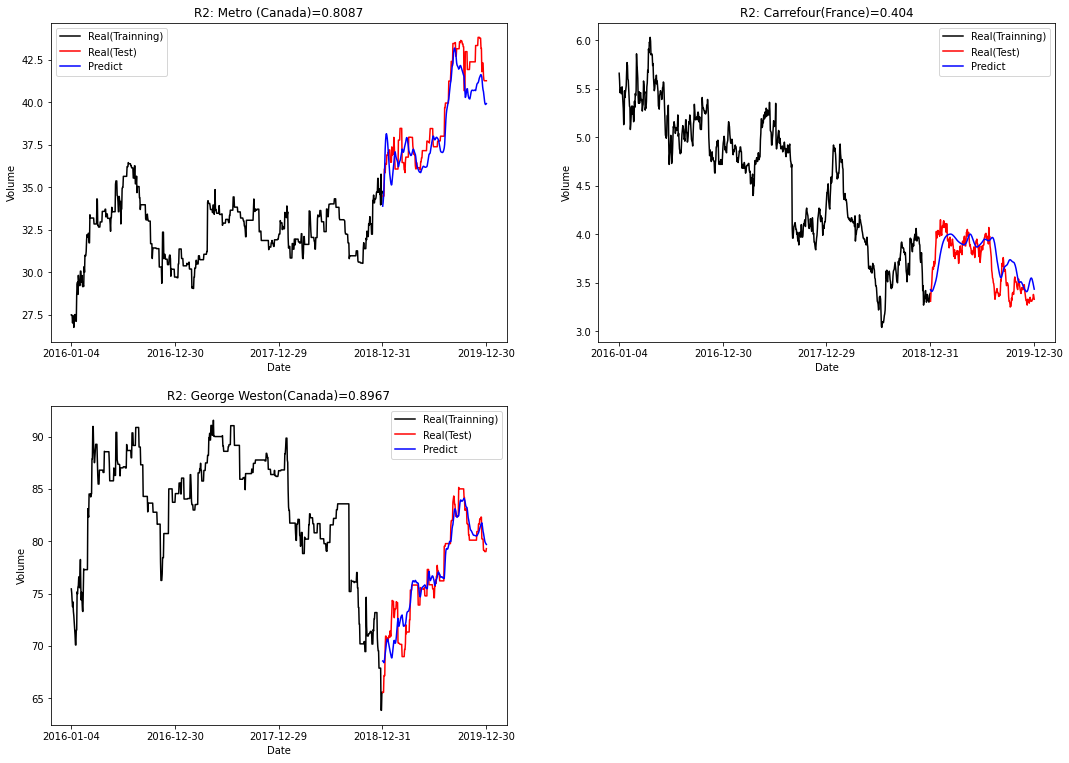

R2-3companies_average=0.7031

R2_scores_lists=[0.8087, 0.404, 0.8967, 0.7031]


In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}回目")
  all_in_all(all_data, num_company=3, input_num=[2], output_category=['High'], output_num=[2], outputs_company=3,
           train_size=754, time_step=60, epochs=50, units=100)

1周目
[Arguments]
num_company=4社 ['Royal Ahold Delhaize(Netherlands)', 'AEON(Japan)', 'Seven & I Holdings (Japan)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 27s 187ms/step - loss: 0.5634
Epoch 2/50
22/22 [==============================] - 4s 178ms/step - loss: 0.1763
Epoch 3/50
22/22 [==============================] - 4s 179ms/step - loss: 0.1712
Epoch 4/50
22/22 [==============================] - 4s 181ms/step - loss: 0.1055
Epoch 5/50
22/22 [==============================] - 4s 178ms/step - loss: 0.1079
Epoch 6/50
22/22 [==============================] - 4s 178ms/step - loss: 0.0894
Epoch 7/50
22/22 [==============================] - 4s 176ms/step - loss: 0.0785
E

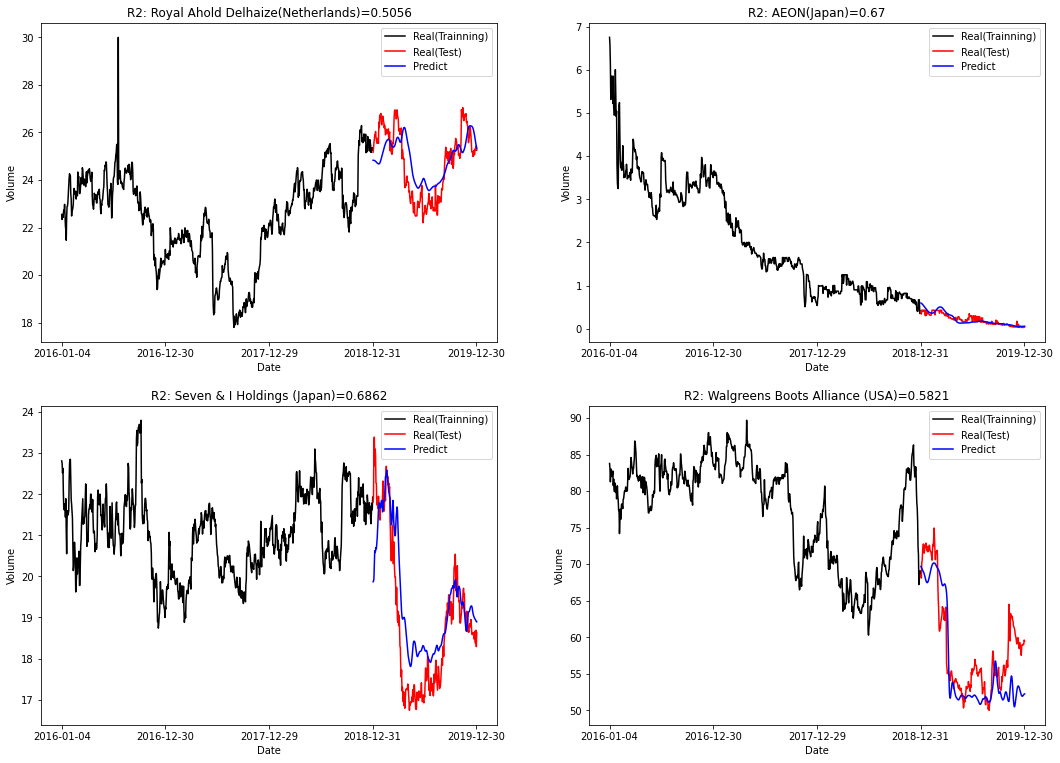

R2-4companies_average=0.611

R2_scores_lists=[0.5056, 0.67, 0.6862, 0.5821, 0.611]
2周目
[Arguments]
num_company=4社 ['Carrefour(France)', 'J.Sainsbury(Britain)', 'Tesco(Britain)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 186ms/step - loss: 0.3445
Epoch 2/50
22/22 [==============================] - 4s 183ms/step - loss: 0.1092
Epoch 3/50
22/22 [==============================] - 4s 184ms/step - loss: 0.0819
Epoch 4/50
22/22 [==============================] - 4s 182ms/step - loss: 0.0816
Epoch 5/50
22/22 [==============================] - 4s 183ms/step - loss: 0.0730
Epoch 6/50
22/22 [==============================] - 4s 183ms/step - loss: 0.0565
Epoch 7/50
22/22 [

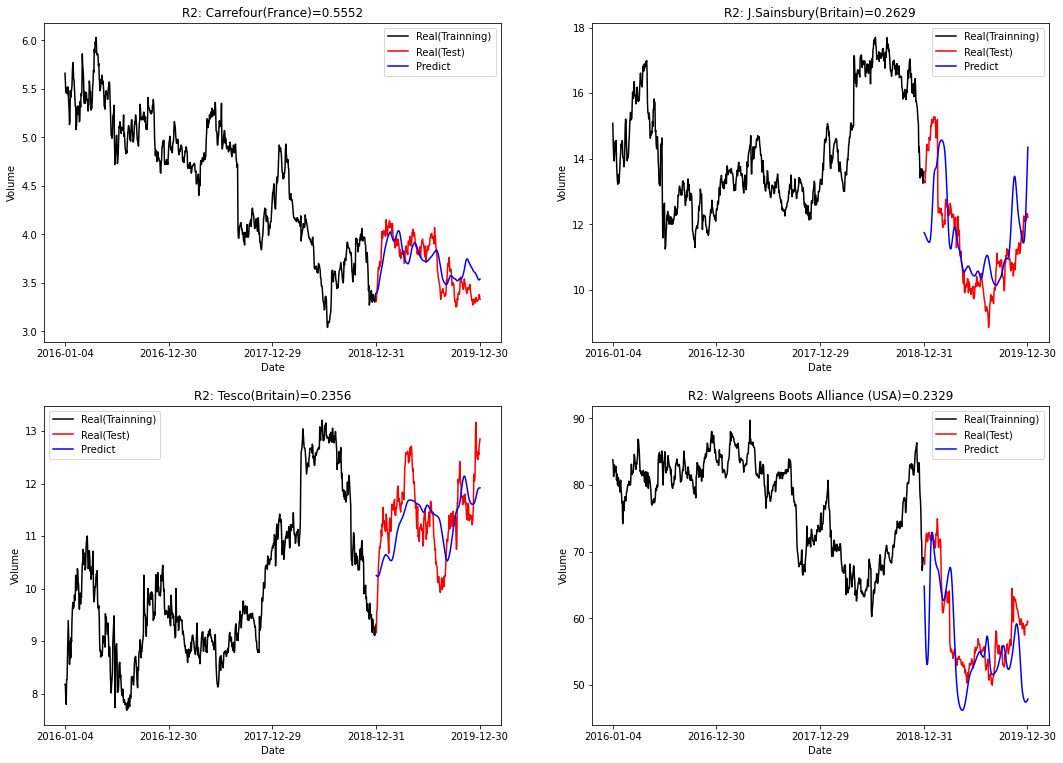

R2-4companies_average=0.3217

R2_scores_lists=[0.5552, 0.2629, 0.2356, 0.2329, 0.3217]
3周目
[Arguments]
num_company=4社 ['AEON(Japan)', 'Tesco(Britain)', 'Kroger(USA)', 'Seven & I Holdings (Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 182ms/step - loss: 0.2984
Epoch 2/50
22/22 [==============================] - 4s 182ms/step - loss: 0.0500
Epoch 3/50
22/22 [==============================] - 4s 182ms/step - loss: 0.0434
Epoch 4/50
22/22 [==============================] - 4s 181ms/step - loss: 0.0402
Epoch 5/50
22/22 [==============================] - 4s 182ms/step - loss: 0.0341
Epoch 6/50
22/22 [==============================] - 4s 183ms/step - loss: 0.0293
Epoch 7/50
22/22 [===============

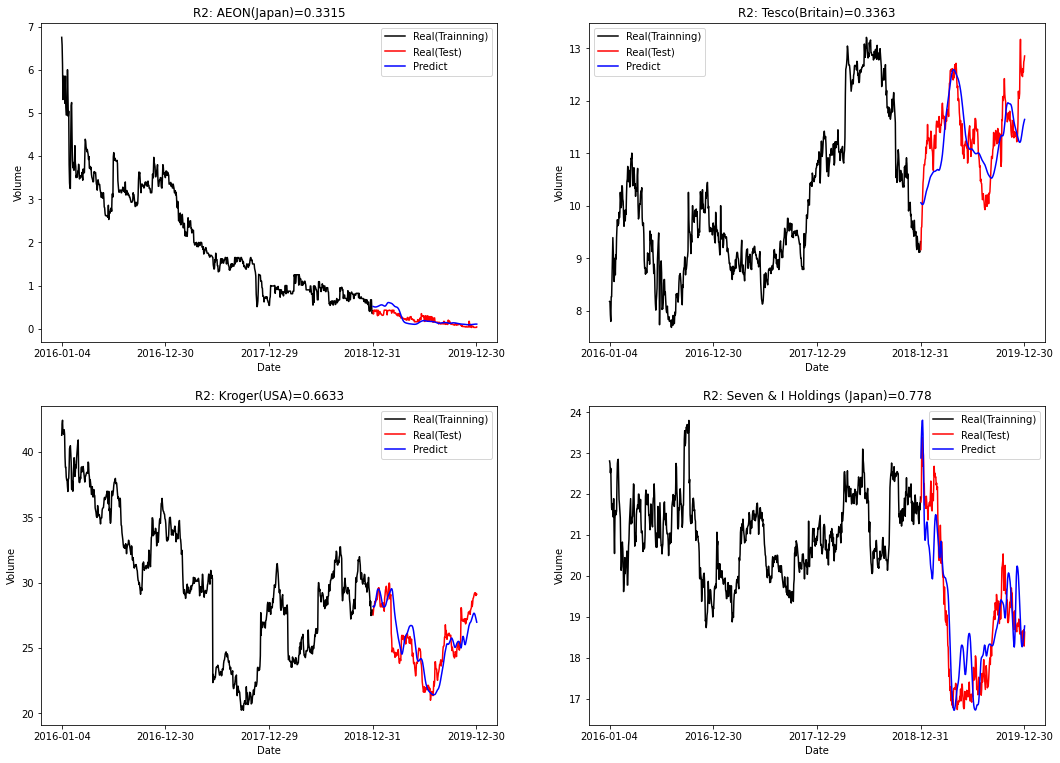

R2-4companies_average=0.5273

R2_scores_lists=[0.3315, 0.3363, 0.6633, 0.778, 0.5273]
4周目
[Arguments]
num_company=4社 ['Carrefour(France)', 'Tesco(Britain)', 'Kroger(USA)', 'Metro (Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 10s 185ms/step - loss: 0.4650
Epoch 2/50
22/22 [==============================] - 4s 189ms/step - loss: 0.1120
Epoch 3/50
22/22 [==============================] - 4s 185ms/step - loss: 0.0797
Epoch 4/50
22/22 [==============================] - 4s 183ms/step - loss: 0.0735
Epoch 5/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0675
Epoch 6/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0508
Epoch 7/50
22/22 [======================

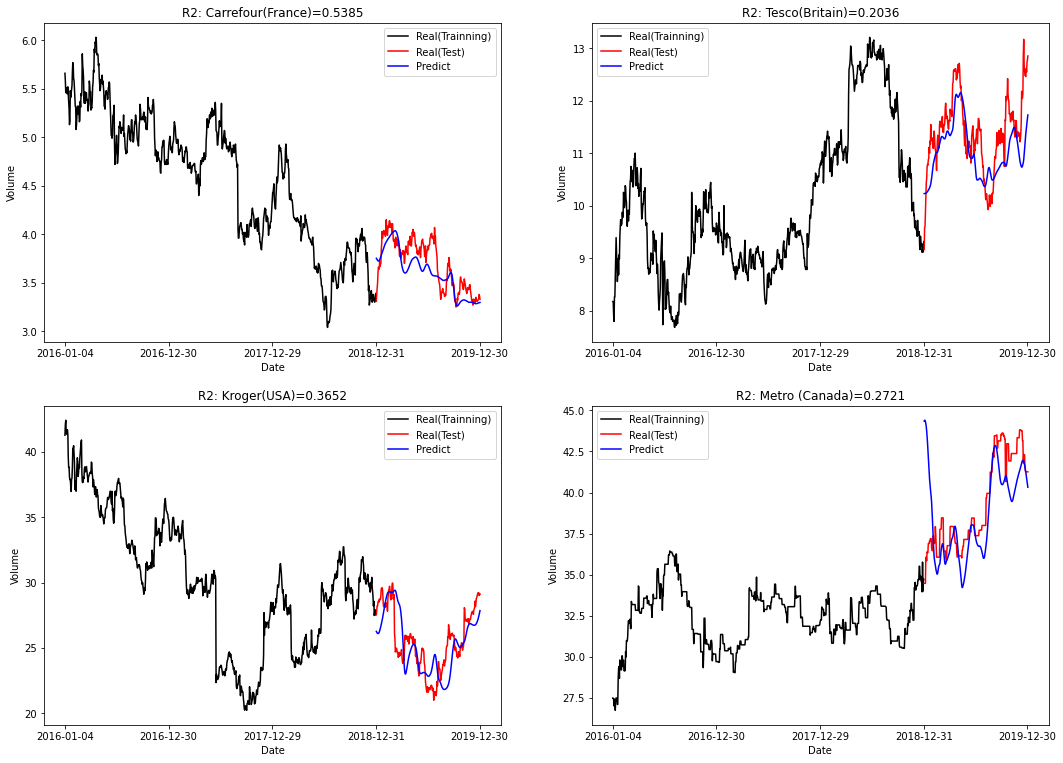

R2-4companies_average=0.3448

R2_scores_lists=[0.5385, 0.2036, 0.3652, 0.2721, 0.3448]
5周目
[Arguments]
num_company=4社 ['Walgreens Boots Alliance (USA)', 'Metro (Canada)', 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 184ms/step - loss: 0.3916
Epoch 2/50
22/22 [==============================] - 4s 187ms/step - loss: 0.1639
Epoch 3/50
22/22 [==============================] - 4s 184ms/step - loss: 0.1296
Epoch 4/50
22/22 [==============================] - 4s 184ms/step - loss: 0.1162
Epoch 5/50
22/22 [==============================] - 4s 191ms/step - loss: 0.0934
Epoch 6/50
22/22 [==============================] - 4s 182ms/step - loss: 0.0911
Epoch 7

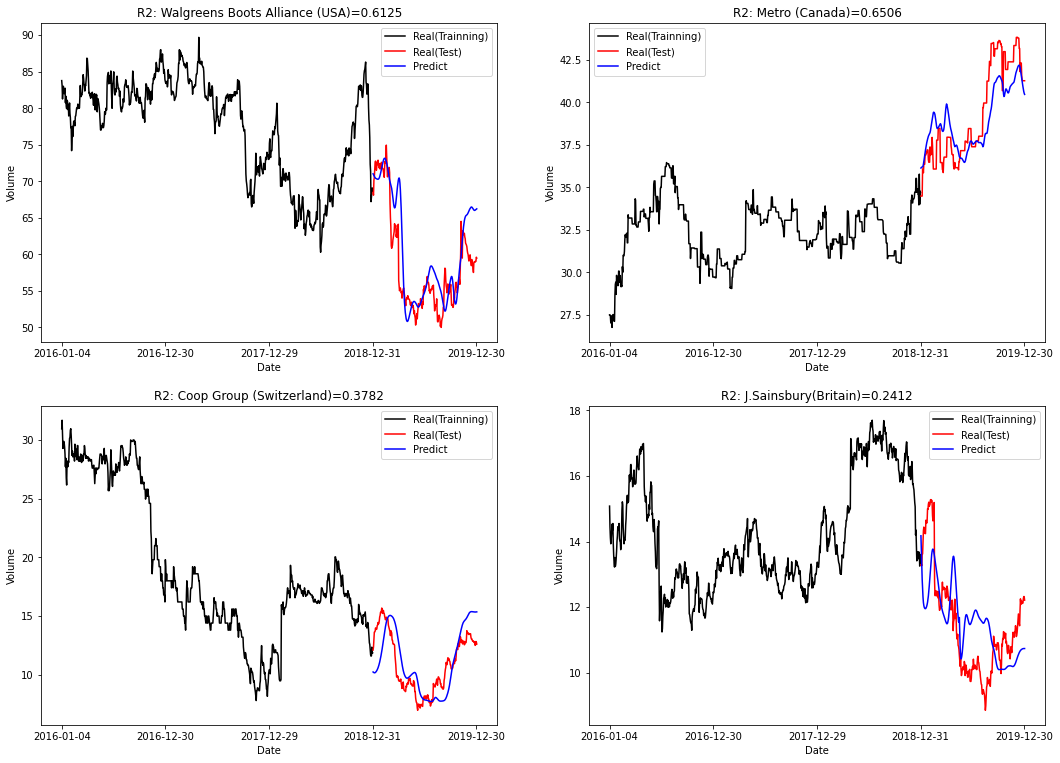

R2-4companies_average=0.4706

R2_scores_lists=[0.6125, 0.6506, 0.3782, 0.2412, 0.4706]
6周目
[Arguments]
num_company=4社 ['Tesco(Britain)', 'J.Sainsbury(Britain)', 'Seven & I Holdings (Japan)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 192ms/step - loss: 0.4944
Epoch 2/50
22/22 [==============================] - 4s 189ms/step - loss: 0.1251
Epoch 3/50
22/22 [==============================] - 4s 189ms/step - loss: 0.0806
Epoch 4/50
22/22 [==============================] - 4s 190ms/step - loss: 0.0709
Epoch 5/50
22/22 [==============================] - 4s 187ms/step - loss: 0.0613
Epoch 6/50
22/22 [==============================] - 4s 187ms/step - loss: 0.0563
Epoch 7/50
22/22 [

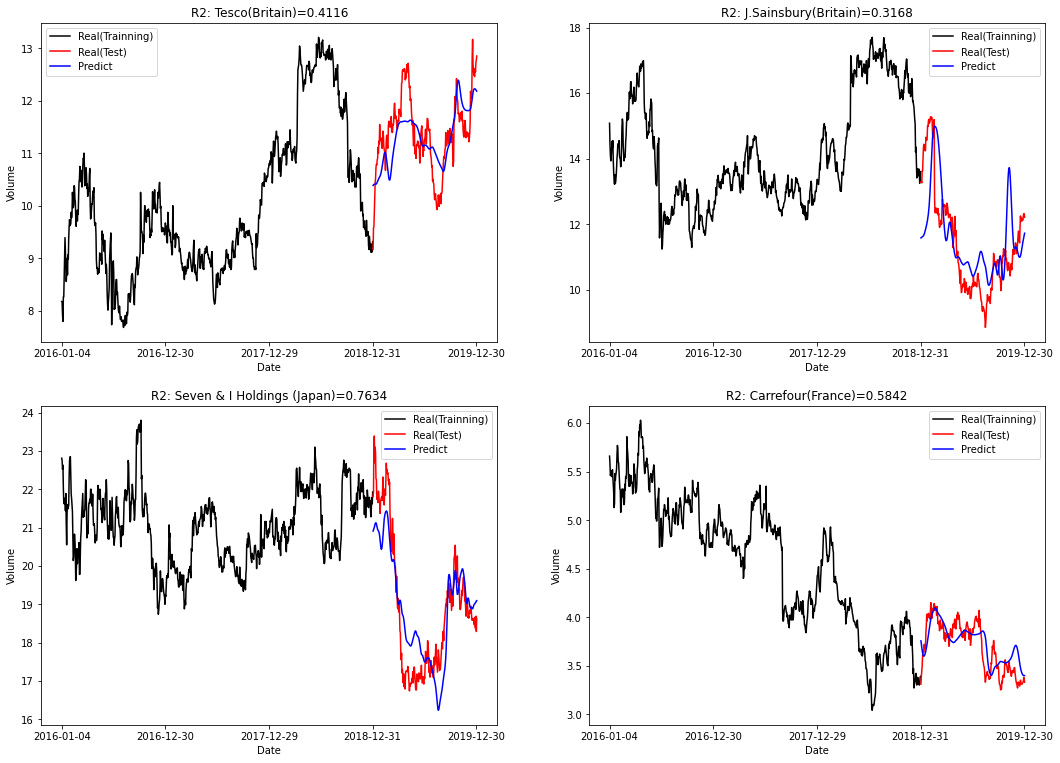

R2-4companies_average=0.519

R2_scores_lists=[0.4116, 0.3168, 0.7634, 0.5842, 0.519]
7周目
[Arguments]
num_company=4社 ['Royal Ahold Delhaize(Netherlands)', 'George Weston(Canada)', 'J.Sainsbury(Britain)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 11s 187ms/step - loss: 0.5730
Epoch 2/50
22/22 [==============================] - 4s 188ms/step - loss: 0.1886
Epoch 3/50
22/22 [==============================] - 4s 184ms/step - loss: 0.1549
Epoch 4/50
22/22 [==============================] - 4s 188ms/step - loss: 0.1416
Epoch 5/50
22/22 [==============================] - 4s 186ms/step - loss: 0.1137
Epoch 6/50
22/22 [==============================] - 4s 186ms/step - loss: 

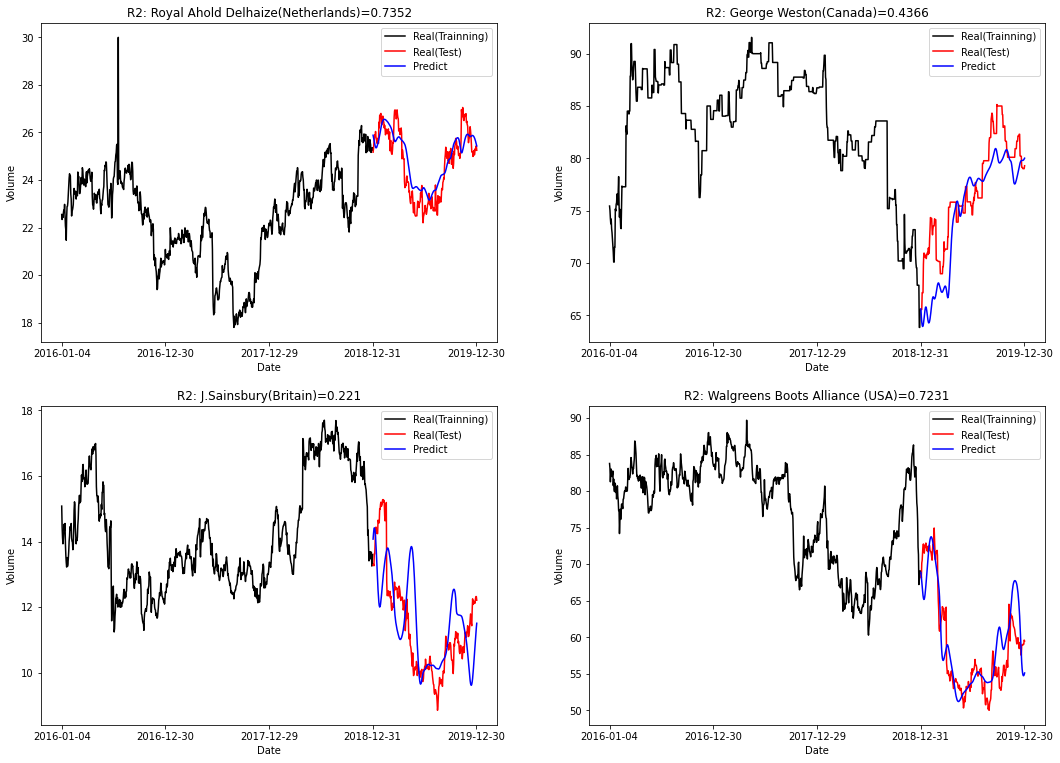

R2-4companies_average=0.529

R2_scores_lists=[0.7352, 0.4366, 0.221, 0.7231, 0.529]
8周目
[Arguments]
num_company=4社 ['Walgreens Boots Alliance (USA)', 'George Weston(Canada)', 'Royal Ahold Delhaize(Netherlands)', 'AEON(Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 10s 195ms/step - loss: 0.5362
Epoch 2/50
22/22 [==============================] - 4s 189ms/step - loss: 0.1773
Epoch 3/50
22/22 [==============================] - 4s 188ms/step - loss: 0.1404
Epoch 4/50
22/22 [==============================] - 4s 192ms/step - loss: 0.1066
Epoch 5/50
22/22 [==============================] - 4s 184ms/step - loss: 0.0875
Epoch 6/50
22/22 [==============================] - 4s 189ms/step - loss: 0.0918
Epo

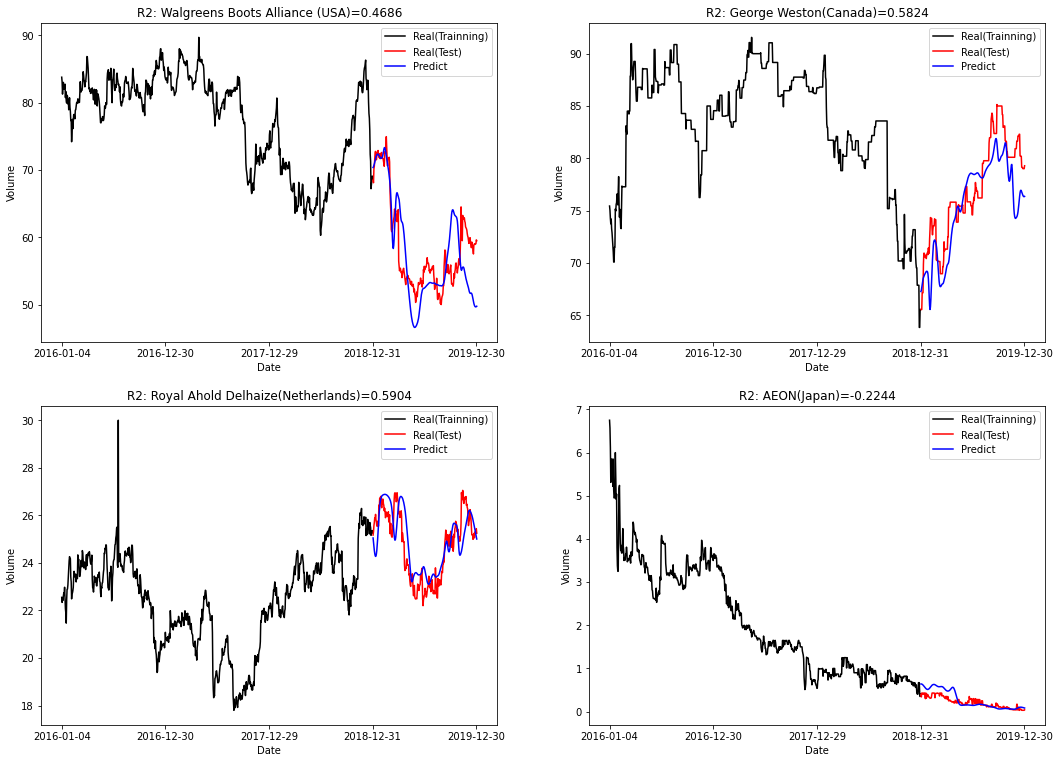

R2-4companies_average=0.3543

R2_scores_lists=[0.4686, 0.5824, 0.5904, -0.2244, 0.3543]
9周目
[Arguments]
num_company=4社 ['Royal Ahold Delhaize(Netherlands)', 'Kroger(USA)', 'Seven & I Holdings (Japan)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 193ms/step - loss: 0.5336
Epoch 2/50
22/22 [==============================] - 4s 189ms/step - loss: 0.2628
Epoch 3/50
22/22 [==============================] - 4s 189ms/step - loss: 0.1611
Epoch 4/50
22/22 [==============================] - 4s 191ms/step - loss: 0.1162
Epoch 5/50
22/22 [==============================] - 4s 191ms/step - loss: 0.1165
Epoch 6/50
22/22 [==============================] - 4s 190ms/step - loss: 0

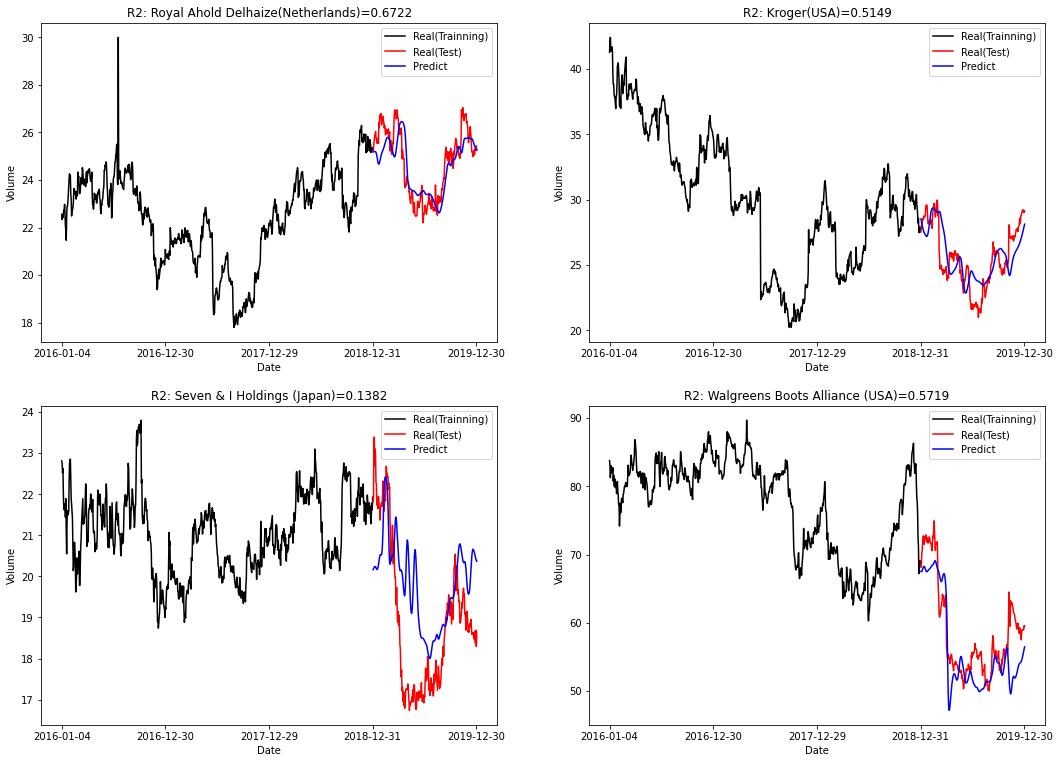

R2-4companies_average=0.4743

R2_scores_lists=[0.6722, 0.5149, 0.1382, 0.5719, 0.4743]
10周目
[Arguments]
num_company=4社 ['Metro (Canada)', 'Kroger(USA)', 'Coop Group (Switzerland)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2[Volume以外１つを予測]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 11s 193ms/step - loss: 0.5256
Epoch 2/50
22/22 [==============================] - 4s 190ms/step - loss: 0.1819
Epoch 3/50
22/22 [==============================] - 4s 190ms/step - loss: 0.1688
Epoch 4/50
22/22 [==============================] - 4s 195ms/step - loss: 0.1755
Epoch 5/50
22/22 [==============================] - 4s 197ms/step - loss: 0.1413
Epoch 6/50
22/22 [==============================] - 4s 191ms/step - loss: 0.1396
Epoch 7/50
22/2

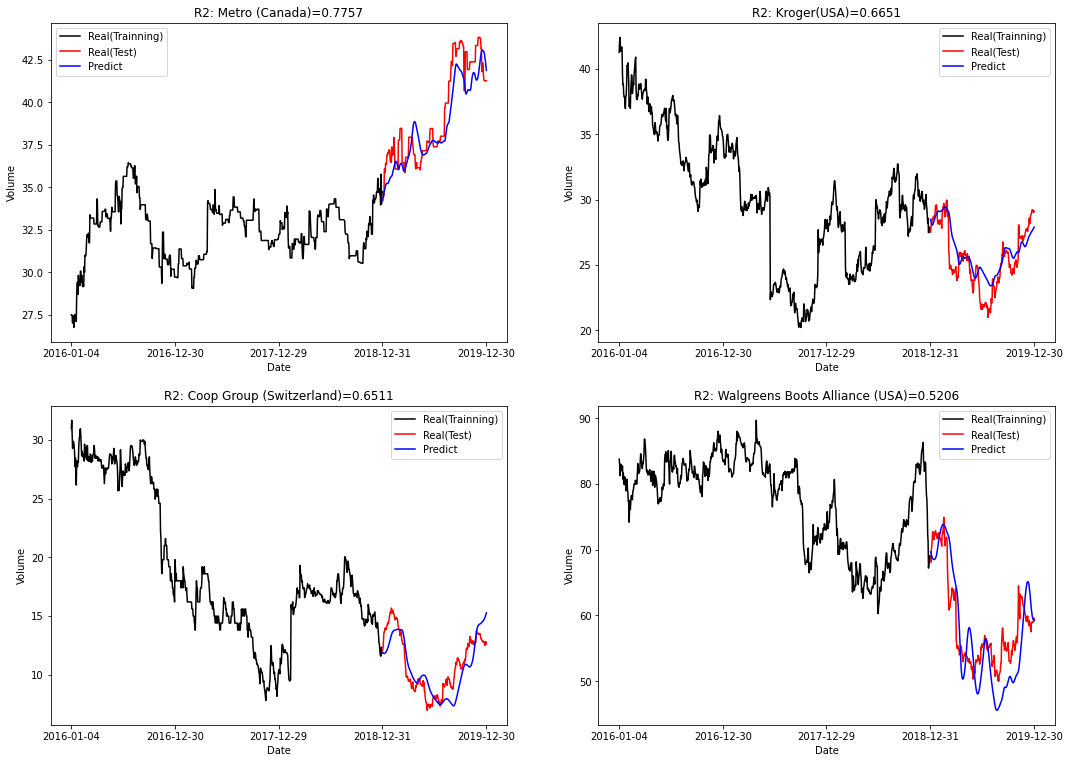

R2-4companies_average=0.6531

R2_scores_lists=[0.7757, 0.6651, 0.6511, 0.5206, 0.6531]


In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=4, input_num=[2], output_category=['High'], output_num=[2], outputs_company=4,
           train_size=754, time_step=60, epochs=50, units=100)

In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=5, input_num=[2], output_category=['High'], output_num=[2], outputs_company=5,
           train_size=754, time_step=60, epochs=50, units=100)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=6, input_num=[2], output_category=['High'], output_num=[2], outputs_company=6,
           train_size=754, time_step=60, epochs=50, units=100)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=7, input_num=[2], output_category=['High'], output_num=[2], outputs_company=7,
           train_size=754, time_step=60, epochs=50, units=100)

Output hidden; open in https://colab.research.google.com to view.

## Result(`High`)

In [ ]:
import matplotlib.pyplot as plt
# experiment data -High Price
R2=[0.7116, 0.7895, 0.908, 0.8719, 0.8817, 0.8958, 0.9173, 0.8944, 0.8722, 0.8939]
R3=[0.7029, 0.7508, 0.6648, 0.5793, 0.3363, 0.5138, 0.7184, 0.4401, 0.6204, 0.7031]
R4=[0.611, 0.3217, 0.5273, 0.3448, 0.4706, 0.519, 0.529, 0.3543, 0.4743, 0.653]
R5=[0.5604, 0.3311, 0.4279, 0.3584, 0.4336, 0.1215, 0.5458, 0.5146, 0.5281, 0.28942]
R6=[0.2805, 0.4924, 0.4264, 0.3275, 0.3902, 0.08, 0.3952, 0.1184, 0.4049, 0.3604]
R7=[0.2926, 0.3132, .3391, 0.3263, 0.2817, 0.352, 0.4261, 0.2279, 0.2014, 0.2899]
R2_scores=(R2, R3, R4, R5, R6, R7)
fix, ax = plt.subplots()
boxplots = ax.boxplot(R2_scores)
ax.set_xticklabels(['n=2', 'n=3', 'n=4', 'n=5', 'n=6', 'n=7'])
plt.title('R2-BOXPLOT')
plt.grid()
plt.show()

# `Volume` N=2~7(Random＊10set) Box Plot 作成用

In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  all_in_all(all_data, num_company=2, input_num=[6], output_category=['Volume'], output_num=[6], outputs_company=2,
           train_size=754, time_step=60, epochs=50, units=100)
  
#Arguments: original_all_data, num_company=11, input_num=[2], output_category=['High'], output_num=[2], outputs_company=11, train_size=754, time_step=60, epochs=20, units=50

True
[Arguments]
num_company=2社 ['George Weston(Canada)', 'Seven & I Holdings (Japan)']
input_item=[6], outout_item=[6], output_category=['Volume']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-1[Volume1つを予測]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 232ms/step - loss: 0.9118
Epoch 2/50
22/22 [==============================] - 5s 228ms/step - loss: 2.2456
Epoch 3/50
22/22 [==============================] - 5s 210ms/step - loss: 2.0902
Epoch 4/50
22/22 [==============================] - 5s 208ms/step - loss: 1.2029
Epoch 5/50
22/22 [==============================] - 5s 220ms/step - loss: 1.0896
Epoch 6/50
22/22 [==============================] - 5s 224ms/step - loss: 0.9584
Epoch 7/50
22/22 [==============================] - 4s 203ms/step - loss: 0.8457
Epoch 8/50
22/22 [==============================] - 4s 201ms/

KeyboardInterrupt: ignored